## **Amazon Sentiment Analysis using Logistic Regression and SVM** 

### **About the dataset:**

The Amazon reviews full score dataset is constructed by randomly taking 600,000 training samples and 130,000 testing samples for each review score from 1 to 5. In total there are 3,000,000 trainig samples and 650,000 testing samples.

The files train.csv and test.csv contain all the training samples as comma-sparated values. There are 3 columns in them, corresponding to class index (1 to 5), review title and review text. The review title and text are escaped using double quotes ("), and any internal double quote is escaped by 2 double quotes (""). New lines are escaped by a backslash followed with an "n" character, that is "\n".

Dataset link: https://drive.google.com/file/d/0Bz8a_Dbh9QhbZVhsUnRWRDhETzA/view?usp=drive_link&resourcekey=0-Rp0ynafmZGZ5MflGmvwLGg

Kaggle link: https://www.kaggle.com/datasets/bittlingmayer/amazonreviews/data

In [1]:
import re
import nltk
import pickle
import pandas as pd
import numpy as np
import requests

In [2]:
# Data processing
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [3]:
# Feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from yellowbrick.text import FreqDistVisualizer

In [4]:
# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn import set_config

In [8]:
# Evaluation
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [9]:
# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
from PIL import Image
from wordcloud import WordCloud,  ImageColorGenerator

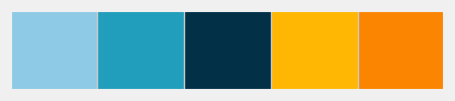

In [10]:
style.use("fivethirtyeight")
colors = ["#8ecae6", "#219ebc", "#023047", "#ffb703", "#fb8500"]
palette = sns.color_palette(colors)
sns.palplot(sns.color_palette(colors))
plt.show()
style.use("fivethirtyeight")

#### **Importing the Dataset:**

In [96]:
data = pd.read_csv('amazon_review_full_csv/train.csv', header=None)
data.head(10)

,0,1,2
0,3,more like funchuck,Gave this to my dad for a gag gift after direc...
1,5,Inspiring,I hope a lot of people hear this cd. We need m...
2,5,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
3,4,Chrono Cross OST,The music of Yasunori Misuda is without questi...
4,5,Too good to be true,Probably the greatest soundtrack in history! U...
5,5,There's a reason for the price,"There's a reason this CD is so expensive, even..."
6,1,Buyer beware,"This is a self-published book, and if you want..."
7,4,"Errors, but great story",I was a dissapointed to see errors on the back...
8,1,The Worst!,A complete waste of time. Typographical errors...
9,1,Oh please,I guess you have to be a romance novel lover f...


In [12]:
data.shape

(3000000, 3)

#### **Modifying the Dataset:**

We first name the columns as "Rating", "Title" and "Review".

In [13]:
data.columns = ["Rating", "Title", "Review"]
data.head()

,Rating,Title,Review
0,3,more like funchuck,Gave this to my dad for a gag gift after direc...
1,5,Inspiring,I hope a lot of people hear this cd. We need m...
2,5,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
3,4,Chrono Cross OST,The music of Yasunori Misuda is without questi...
4,5,Too good to be true,Probably the greatest soundtrack in history! U...


We then combine the "Review" and "Title" column into one, as it should not contradict the overall sentiment.

In [14]:
data["Review"] = data["Title"] + " " + data["Review"]
data = data[['Review', 'Rating']]
data.head()

,Review,Rating
0,more like funchuck Gave this to my dad for a g...,3
1,Inspiring I hope a lot of people hear this cd....,5
2,The best soundtrack ever to anything. I'm read...,5
3,Chrono Cross OST The music of Yasunori Misuda ...,4
4,Too good to be true Probably the greatest soun...,5


The sentiment to each review is added by considering a rating above 3 as "Positive", below 3 as "Negative" and equal to 3 as "Neutral".

In [15]:
def sentiment(label):
    if label<3:
        return "Negative"
    elif label>3:
        return "Positive"
    else:
        return "Neutral"

In [16]:
data['Sentiment'] = data["Rating"].apply(sentiment)
data.head(10)

,Review,Rating,Sentiment
0,more like funchuck Gave this to my dad for a g...,3,Neutral
1,Inspiring I hope a lot of people hear this cd....,5,Positive
2,The best soundtrack ever to anything. I'm read...,5,Positive
3,Chrono Cross OST The music of Yasunori Misuda ...,4,Positive
4,Too good to be true Probably the greatest soun...,5,Positive
5,There's a reason for the price There's a reaso...,5,Positive
6,"Buyer beware This is a self-published book, an...",1,Negative
7,"Errors, but great story I was a dissapointed t...",4,Positive
8,The Worst! A complete waste of time. Typograph...,1,Negative
9,Oh please I guess you have to be a romance nov...,1,Negative


#### **Data Analysis:**

In [17]:
data.shape

(3000000, 3)

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 3 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   Review     object
 1   Rating     int64 
 2   Sentiment  object
dtypes: int64(1), object(2)
memory usage: 68.7+ MB


In [19]:
data.value_counts("Rating")

Rating
1    600000
2    600000
3    600000
4    600000
5    600000
Name: count, dtype: int64

In [20]:
data.value_counts("Sentiment")

Sentiment
Negative    1200000
Positive    1200000
Neutral      600000
Name: count, dtype: int64

C:\Users\Amritha\AppData\Local\Temp\ipykernel_20104\2359462227.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Sentiment", data=data,  palette=["#f8de7e","#32fa53",'#fa3232'])


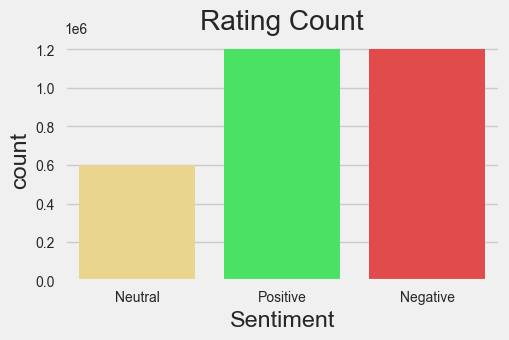

In [21]:
plt.figure(figsize=(5,3))
sns.countplot(x="Sentiment", data=data,  palette=["#f8de7e","#32fa53",'#fa3232'])
plt.title("Rating Count")
plt.show()

In [22]:
data["Rating"].value_counts()/len(data)

Rating
3    0.2
5    0.2
4    0.2
1    0.2
2    0.2
Name: count, dtype: float64

In [23]:
data["Sentiment"].value_counts()/len(data)

Sentiment
Positive    0.4
Negative    0.4
Neutral     0.2
Name: count, dtype: float64

In [24]:
data.isna().sum()

Review       188
Rating         0
Sentiment      0
dtype: int64

We can see that there are no null values in Ratings or Sentiments, so we do not have to drop any rows.
However, there are 188 rows that are empty, so we fill it with an empty string.

In [25]:
data = data.fillna(' ')
data.isna().sum()

Review       0
Rating       0
Sentiment    0
dtype: int64

**Number of characters present in each Review:**

Here I range the number of characters by 500 chars and so on.

In [26]:
text_len = data['Review'].groupby(pd.cut(data['Review'].str.len(), np.arange(0, 20000+500, 500))).count().rename_axis(['Range']).reset_index()
text_len.head()

,Range,Review
0,"(0, 500]",1911735
1,"(500, 1000]",1071380
2,"(1000, 1500]",16885
3,"(1500, 2000]",0
4,"(2000, 2500]",0


In [27]:
text_len_50 = text_len[text_len['Review'] > 50]
text_len_50

,Range,Review
0,"(0, 500]",1911735
1,"(500, 1000]",1071380
2,"(1000, 1500]",16885


C:\Users\Amritha\AppData\Local\Temp\ipykernel_20104\4000903183.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.barplot( x=text_len_50['Range'][0:10], y=text_len_50['Review'][0:10], palette=palette)
C:\Users\Amritha\AppData\Local\Temp\ipykernel_20104\4000903183.py:2: UserWarning: 
The palette list has fewer values (5) than needed (40) and will cycle, which may produce an uninterpretable plot.
  g = sns.barplot( x=text_len_50['Range'][0:10], y=text_len_50['Review'][0:10], palette=palette)
C:\Users\Amritha\AppData\Local\Temp\ipykernel_20104\4000903183.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90)


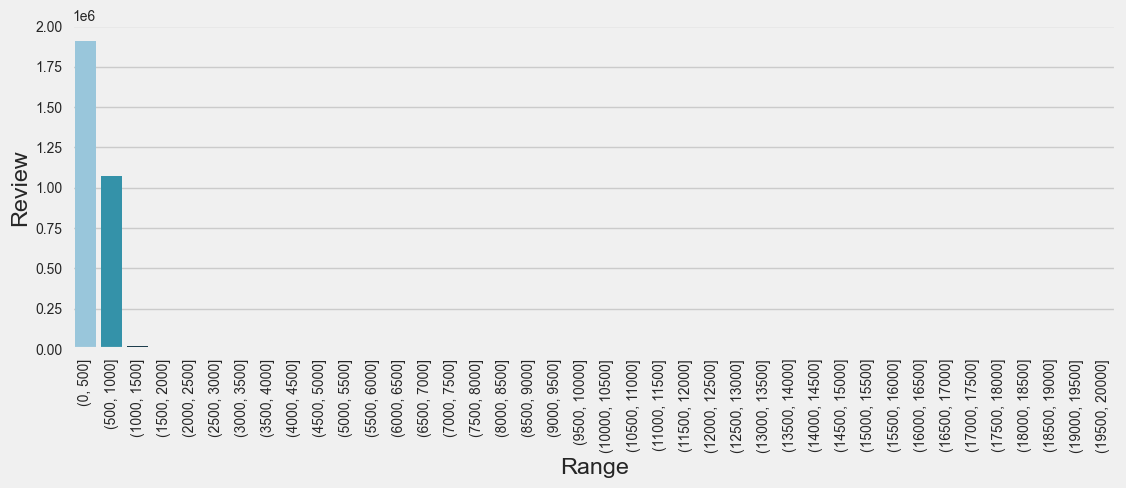

In [28]:
plt.figure(figsize=(12, 4))
g = sns.barplot( x=text_len_50['Range'][0:10], y=text_len_50['Review'][0:10], palette=palette)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.show()

C:\Users\Amritha\AppData\Local\Temp\ipykernel_20104\1778809724.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=data, x=data['Review'].str.len(), palette=palette)


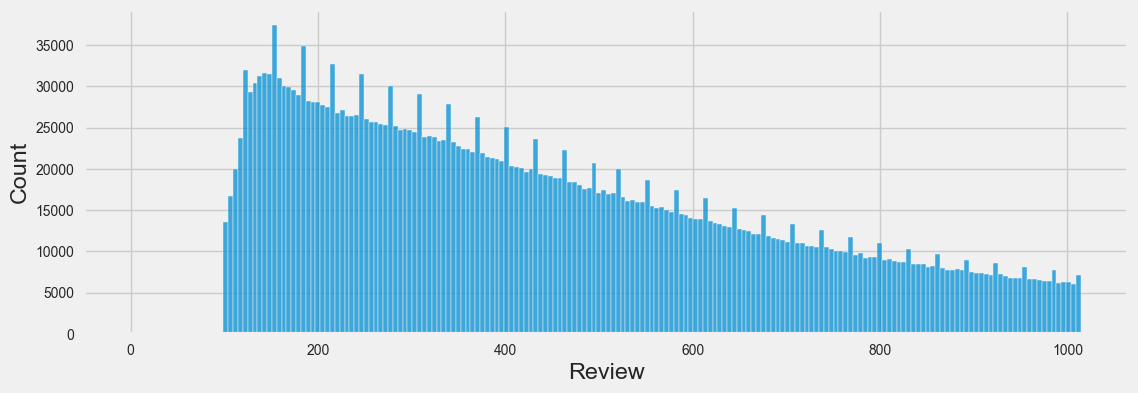

In [29]:
plt.figure(figsize=(12, 4))
sns.histplot(data=data, x=data['Review'].str.len(), palette=palette)
plt.show()

#### **Sampling the data:**
Since there are over 35 million reviews in this dataset, we will only use a portion of this for training our models. We will use Stratified Shuffle Split for this.

Benefits of StratifiedShuffleSplit:

- Maintains class balance: This is crucial for sentiment analysis where you have different classes representing positive, negative, and neutral reviews. Stratified sampling ensures the sampled data reflects the same proportion of each class as your original dataset, preventing biases in your model's training.
- Reduces computational cost: Training on a smaller sample is significantly faster and less resource-intensive compared to using the entire dataset.
- Provides representative data: Stratified sampling ensures the selected data is representative of the entire population, leading to a more robust and generalizable model.

In [30]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.97)
for train_index, test_index in split.split(data, data["Sentiment"]): 
    strat_data = data.reindex(train_index)

In [31]:
strat_data.head(10)

,Review,Rating,Sentiment
1327409,Disappointing Read from Lawhead Stephen Lawhea...,1,Negative
1264172,Raunchy! Bought this for my father who was in ...,2,Negative
1372147,"awesome for me it fits everything,has room for...",5,Positive
1205251,It's Bob Dylan All Over Again! I got this CD m...,5,Positive
2066985,Classic in the making!! Truly a masterpiece! K...,5,Positive
1350048,"Not Quit Heaven, more like Purgatory After lis...",2,Negative
2595684,There is better out there.... Despite the prai...,2,Negative
2781668,A new approach to Beethoven This is for sure a...,3,Neutral
1914497,Penny Marshall's finest film. Awakenings is a ...,3,Neutral
2208308,"Not the best Greatest Hits compelation, but it...",5,Positive


In [32]:
strat_data.shape

(90000, 3)

In [33]:
strat_data.value_counts("Sentiment")

Sentiment
Negative    36000
Positive    36000
Neutral     18000
Name: count, dtype: int64

#### **Cleaning data:**

Cleaning data includes

- Tokenization: Tokenization is the process of converting text into tokens before transforming it into vectors. 
- Stop Words Removal: Stop words are the most commonly occuring words which are not relevant in the context of the data and do not contribute any deeper meaning to the phrase. 
- Normalization: Words which look different due to casing or written another way but are the same in meaning need to be process correctly. Normalisation processes ensure that these words are treated equally. This includes:
    - Casing the characters: Converting character to the same case so the same words are recognised as the same. In this case we converted to lowercase
    - Negation Handling
- Stemming: Stemming generates the base word from the inflected word by removing the affixes of the word.
- Lemmetization: This process finds the base or dictionary form of the word known as the lemma.

In [45]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Amritha\AppData\Roaming\nltk_data...


True

In [34]:
def preprocess_text(text):
    # Make text lowercase and remove links, text in square brackets, punctuation, and words containing numbers
    text = str(text)
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+|\[.*?\]|[^a-zA-Z\s]+|\w*\d\w*', ' ', text)

    # Remove stop words
    stop_words = set(stopwords.words("english"))
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    text = ' '.join(filtered_words).strip()

    # Tokenize
    tokens = nltk.word_tokenize(text)

    # Stemming
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]

    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    lem_tokens = [lemmatizer.lemmatize(token) for token in stemmed_tokens]
    
    return ' '.join(lem_tokens)

For example:

In [35]:
preprocess_text(data["Review"][2])

'best soundtrack ever anyth read lot review say best game soundtrack figur write review disagre bit opinino yasunori mitsuda ultim masterpiec music timeless listen year beauti simpli refus fade price tag pretti stagger must say go buy cd much money one feel would worth everi penni'

In [36]:
preprocess_text(data["Review"][110])

'fabul book complet instrument guid husband timberfram pursuit read much cover bind fallen broken hold best refer diyer look start structur'

We do the same for all the reviews in the dataset.

In [37]:
strat_data["Review"] = strat_data["Review"].apply(preprocess_text)
strat_data.head(10)

,Review,Rating,Sentiment
1327409,disappoint read lawhead stephen lawhead one fa...,1,Negative
1264172,raunchi bought father hospit thought trucker h...,2,Negative
1372147,awesom fit everyth room everyth room two contr...,5,Positive
1205251,bob dylan got cd mostli drive crazi know tune ...,5,Positive
2066985,classic make truli masterpiec kuku music sooo ...,5,Positive
1350048,quit heaven like purgatori listen dj misja hel...,2,Negative
2595684,better despit prais sung men serv tank stori a...,2,Negative
2781668,new approach beethoven sure new interest appro...,3,Neutral
1914497,penni marshal finest film awaken depress film ...,3,Neutral
2208308,best greatest hit compel remast yeah yeah yeah...,5,Positive


#### **Word Cloud:**

In [38]:
txt = "".join(strat_data["Review"].tolist())

In [39]:
len(txt)

21686659

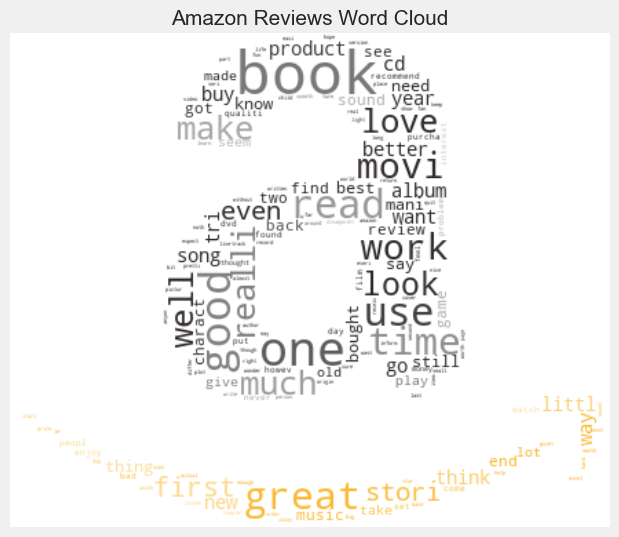

In [40]:
amazon_mask = np.array(Image.open(requests.get('https://pngimg.com/uploads/amazon/amazon_PNG4.png', stream=True).raw))

wc = WordCloud(width = 300, height = 200, random_state=1, background_color='white', colormap='Set2', collocations=False, mask=amazon_mask).generate(txt)
image_colors = ImageColorGenerator(amazon_mask)
wc.recolor(color_func=image_colors)
plt.figure(figsize=(6,6))
plt.axis("off")
plt.tight_layout(pad=0)
plt.imshow(wc, interpolation='bilinear')
plt.title("Amazon Reviews Word Cloud", fontsize = 15)
plt.savefig('wordcloud.png')
plt.show()

#### **Vectorization:**

**Count Vectorization:**

Count vectoriser transforms a given text into a vector on the basis of the frequency of each word that occurs in the entire text. It is helpful when we have multiple such texts, and we wish to convert each word in each text into vectors

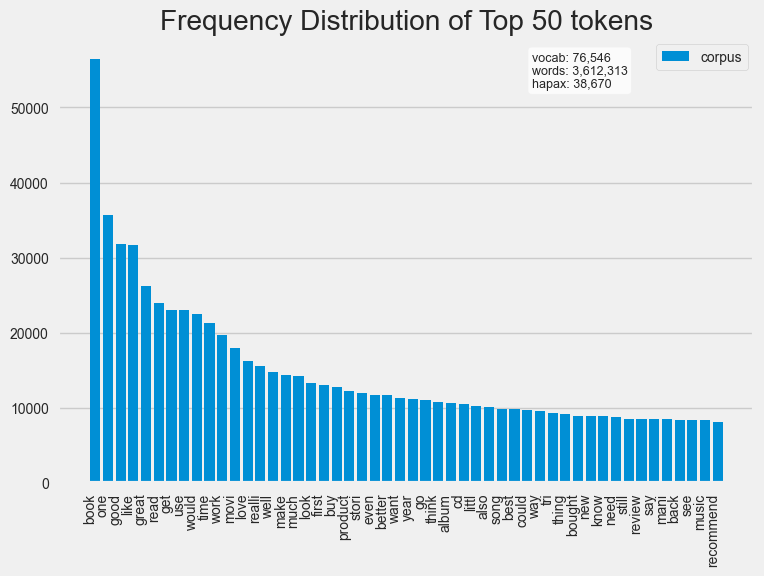

In [41]:
def word_distribution(text):
    vectorizer = CountVectorizer()
    docs = vectorizer.fit_transform(text)
    features = vectorizer.get_feature_names_out()
    
    # Freq Dist Visualizer
    visualizer = FreqDistVisualizer(features=features, orient='v')
    visualizer.fit(docs)
    visualizer.show()

word_distribution(strat_data['Review'])

**TF-IDF Vectorizer:**

Term frequency-inverse document frequency is a text vectorizer that transforms the text into a usable vector. It combines 2 concepts, Term Frequency (TF) and Document Frequency (DF).

- The term frequency is the number of occurrences of a specific term in a document. Term frequency indicates how important a specific term in a document. Term frequency represents every text from the data as a matrix whose rows are the number of documents and columns are the number of distinct terms throughout all documents.

- Document frequency is the number of documents containing a specific term. Document frequency indicates how common the term is.Inverse document frequency (IDF) is the weight of a term, it aims to reduce the weight of a term if the term’s occurrences are scattered throughout all the documents. 

In [42]:
tfidf_vectorizer = TfidfVectorizer(max_features = 5000, ngram_range = (1,3))

In [43]:
X_tfidf = tfidf_vectorizer.fit_transform(strat_data['Review'])
X_tfidf

<90000x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 2936047 stored elements in Compressed Sparse Row format>

In [44]:
X_tfidf.shape

(90000, 5000)

In [46]:
y = strat_data["Sentiment"]

In [47]:
y.shape

(90000,)

### **Training the model using Logistic Regression**

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, random_state = 42,test_size = 0.20)

In [73]:
print(X_train.shape)
print(f"Number of Training Samples: {X_train.shape[0]}")

(72000, 5000)
Number of Training Samples: 72000


In [74]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

c:\Users\Amritha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [75]:
predictedLogReg = logreg.predict(X_test)
np.mean(predictedLogReg == y_test)

0.7108333333333333

In [76]:
inp_test = input("Enter review: ")
print(inp_test)

inp_test = preprocess_text(inp_test)
print("After preprocessing: ", inp_test)

inp_test = tfidf_vectorizer.transform([inp_test])
logreg.predict(inp_test)

i love this
After preprocessing:  love


array(['Positive'], dtype=object)

#### **Model Analysis:**

In [63]:
# classification_report and accuracy_score using sklearn.metrics library
print("Classification Report")
print(f"{classification_report(y_test, predictedLogReg)}")
print(f"Accuracy: {accuracy_score(y_test, predictedLogReg)}")

Classification Report
              precision    recall  f1-score   support

    Negative       0.73      0.81      0.77      7267
     Neutral       0.49      0.28      0.36      3599
    Positive       0.74      0.83      0.78      7134

    accuracy                           0.71     18000
   macro avg       0.66      0.64      0.64     18000
weighted avg       0.69      0.71      0.69     18000

Accuracy: 0.7108333333333333


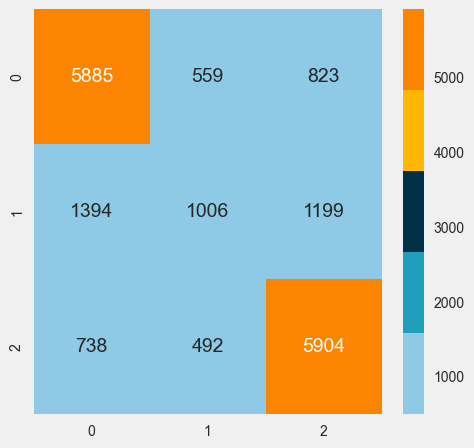

In [65]:
plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix(y_test,predictedLogReg), annot=True, fmt="d", cmap=colors)
plt.show()

### **Training the model using SVM:**

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, random_state = 42, test_size = 0.20)

In [78]:
print(f"Training:\n X = {X_train.shape}\n y = {y_train.shape}")
print(f"Testing:\n X = {X_test.shape}\n y = {y_test.shape}")

Training:
 X = (72000, 5000)
 y = (72000,)
Testing:
 X = (18000, 5000)
 y = (18000,)


In [79]:
svm = SVC(kernel="linear")
svm.fit(X_train, y_train)

SVC(kernel='linear')

In [80]:
y_pred = svm.predict(X_test)

In [81]:
accuracy_score(y_test, y_pred)*100

70.5611111111111

In [91]:
inp_test = input("Enter review: ")
print(inp_test)

inp_test = preprocess_text(inp_test)
print("After preprocessing: ", inp_test)

inp_test = tfidf_vectorizer.transform([inp_test])
svm.predict(inp_test)

this is great
After preprocessing:  great


array(['Positive'], dtype=object)

#### **Model Analysis:**

In [92]:
# classification_report and accuracy_score using sklearn.metrics library
print("Classification Report")
print(f"{classification_report(y_test, y_pred)}")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Classification Report
              precision    recall  f1-score   support

    Negative       0.73      0.80      0.76      7267
     Neutral       0.48      0.28      0.36      3599
    Positive       0.74      0.82      0.78      7134

    accuracy                           0.71     18000
   macro avg       0.65      0.64      0.63     18000
weighted avg       0.68      0.71      0.69     18000

Accuracy: 0.7056111111111111


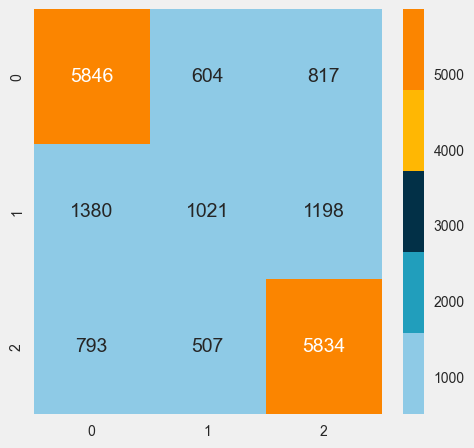

In [93]:
plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap=colors)
plt.show()

#### **Exporting the models as a pickled file:**

In [95]:
pi = {'vectorizer': tfidf_vectorizer, 'logreg': logreg, 'svm': svm}
pickle.dump(pi, open('models' + '.p', 'wb'))